In [3]:
import sys
# !conda install --yes --prefix {sys.prefix} tweepy
# !conda install --yes --prefix {sys.prefix} textblob
# !conda install --yes --prefix {sys.prefix} twython

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /Users/aoliv01/anaconda3

  added / updated specs: 
    - twython


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    twython-3.7.0              |             py_0          26 KB  conda-forge

The following NEW packages will be INSTALLED:

    twython: 3.7.0-py_0 conda-forge


twython 3.7.0: ######################################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [12]:
import nltk
# nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aoliv01/nltk_data...


True

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import twitter_sent
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.patches as mpatches
import copy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
%precision 2

'%.2f'

In [205]:
won = ['JimmyGomezCA', 'JamesThompsonKS', 'karenhandel', 'RalphNorman', 'GregForMontana']
lost = ['AhnforCA34', 'LauraforKansas', 'ossoff', 'Archie4Congress', 'RobQuistforMT']
upcoming = ['realScottWagner', 'WolfForPA', 'AndrewGillum', 'RonDeSantisFL']
pa = ['realScottWagner', 'WolfForPA']
fl = ['AndrewGillum', 'RonDeSantisFL']
ca = ['JimmyGomezCA', 'AhnforCA34']
ks = ['LauraforKansas', 'JamesThompsonKS']
ga = ['karenhandel', 'ossoff']
sc = ['RalphNorman', 'Archie4Congress']
mt = ['GregForMontana', 'RobQuistforMT']
all_file_names = ['GregForMontana', 'RobQuistforMT', 'RalphNorman', 'karenhandel', 'ossoff', 'Archie4Congress', 'LauraforKansas', 'JamesThompsonKS',
            'JimmyGomezCA', 'AhnforCA34', 'AndrewGillum', 'RonDeSantisFL', 'realScottWagner', 'WolfForPA']
all_states = [pa, fl, ca, ks, ga, sc, mt]

In [206]:
frames = {name: pd.read_csv(f'data/{name}.csv', low_memory=True) for name in all_file_names}
greg_mt = frames['GregForMontana']
rob_mt = frames['RobQuistforMT']
karen_ga = frames['karenhandel']
tom_ga = frames['ossoff']
ralph_sc = frames['RalphNorman']
archie_sc = frames['Archie4Congress']
laura_ks = frames['LauraforKansas']
james_ks = frames['JamesThompsonKS']
jimmy_ca = frames['JimmyGomezCA']
ahn_ca = frames['AhnforCA34']
andrew_fl = frames['AndrewGillum']
ron_fl = frames['RonDeSantisFL']
scott_pa = frames['realScottWagner']
tom_pa = frames['WolfForPA']

In [5]:
# null check
# for k, v in frames.items():
#     display(f'{k}', frames[k].isna().sum())

In [6]:
# check for shape
# for k, v in frames.items():
#     display(f'{k}', frames[k].shape)

In [236]:
def extract_from_frame(list):
    retweets = []
    favorites = []
    
    def get_retweets_likes(name, value):
        return frames[name].loc[:, value].tolist()
    
    for name in list:
        retweets.extend(get_retweets_likes(name, 'retweet_count'))
        favorites.extend(get_retweets_likes(name, 'favorite_count'))
    
    return retweets, favorites

wr, wf = extract_from_frame(won)
lr, lf = extract_from_frame(lost)
win_data = {
    'retweets': wr,
    'favorites': wf
}
lost_data = {
    'retweets': lr,
    'favorites': lf
}
win_counts = pd.DataFrame(data=win_data)
loss_counts = pd.DataFrame(data=lost_data)
win_counts['win_loss'] = 'won'
loss_counts['win_loss'] = 'lost'
wl_counts = win_counts.merge(loss_counts, how='outer')
wl_long = pd.melt(wl_counts, 'win_loss', var_name='count')

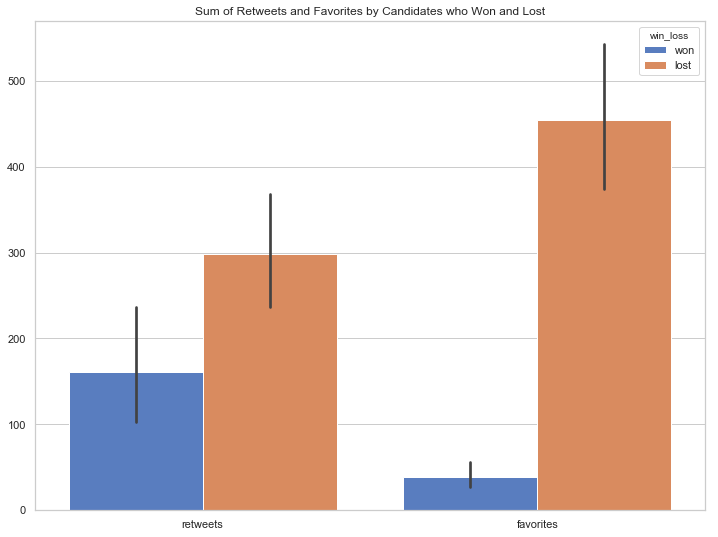

In [237]:
sns.set(rc={'figure.figsize':(12, 9)})
sns.set(style='whitegrid', palette='muted')
sns.barplot(x='count', y='value', hue='win_loss', data=wl_long)
plt.title('Sum of Retweets and Favorites by Candidates who Won and Lost')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [225]:
print('\nWin counts shape:', win_counts.shape, 'Loss counts shape:', loss_counts.shape)
print('=' * 25)
print('\nWins Retweets:')
print('Max:', win_counts.retweets.max(), '| Avg:', win_counts.retweets.mean(), '| Sum:', win_counts.retweets.sum())
print('\nLosses Retweets:')
print('Max:', loss_counts.retweets.max(), '| Avg:', loss_counts.retweets.mean(), '| Sum:', loss_counts.retweets.sum())
print('=' * 25)
print('\nWins Favorites:')
print('Max:', win_counts.favorites.max(), '| Avg:', win_counts.favorites.mean(), '| Sum:', win_counts.favorites.sum())
print('\nLosses Favorites:')
print('Max:', loss_counts.favorites.max(), '| Avg:', loss_counts.favorites.mean(), '| Sum:', loss_counts.favorites.sum())
print('=' * 25)


Win counts shape: (2198, 3) Loss counts shape: (1985, 3)

Wins Retweets:
Max: 49376 | Avg: 160.95313921747044 | Sum: 353775

Losses Retweets:
Max: 37160 | Avg: 298.74609571788415 | Sum: 593011

Wins Favorites:
Max: 15125 | Avg: 38.43630573248408 | Sum: 84483

Losses Favorites:
Max: 33200 | Avg: 454.5324937027708 | Sum: 902247


In [226]:
lost_df = pd.concat([frames[name] for name in lost], ignore_index=True)
won_df = pd.concat([frames[name] for name in won], ignore_index=True)

In [227]:
sia = SentimentIntensityAnalyzer()
def clean_add_sents(frame_in):

    def add_nltk_sents(dict_in):
        count = 0
        while count < len(dict_in):
            probs = sia.polarity_scores(dict_in[count]['text'])
            dict_in[count]['nltk_pos'] = probs['pos']
            dict_in[count]['nltk_neg'] = probs['neg']
            dict_in[count]['nltk_neu'] = probs['neu']
            count += 1
        return dict_in
            
    frame = copy.deepcopy(frame_in)
    temp = frame.to_dict(orient='index')
    cleaned_temp = twitter_sent.TweetHandler.clean_tweet_map_texts(temp)
    sent_temp = add_nltk_sents(cleaned_temp)
    sent_temp = twitter_sent.TweetHandler.add_text_blob_sentiment_map(sent_temp)
    frame = pd.DataFrame().from_dict(sent_temp, orient='index')
    return frame

won_df = clean_add_sents(won_df)
lost_df = clean_add_sents(lost_df)

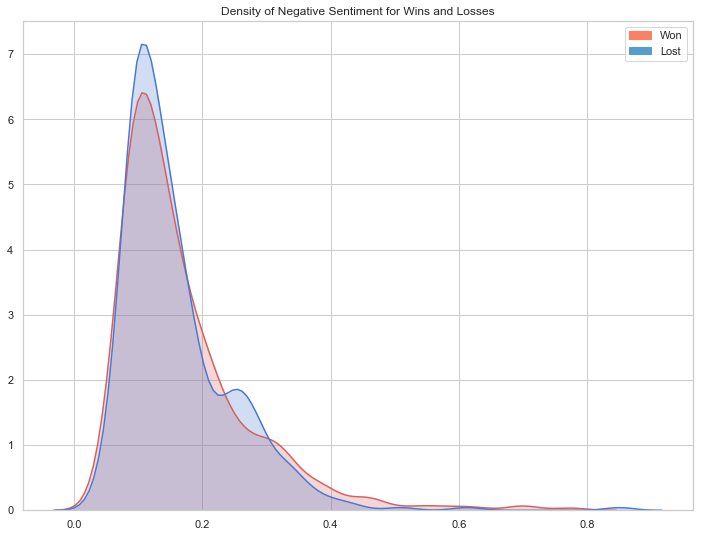

In [228]:
won_neg = won_df.loc[won_df['nltk_neg'] > 0]['nltk_neg']
lost_neg = lost_df.loc[lost_df['nltk_neg'] > 0]['nltk_neg']
p1 = sns.kdeplot(won_neg, shade=True, color='r')
p1 = sns.kdeplot(lost_neg, shade=True, color='b')
red_patch = mpatches.Patch(color=sns.color_palette('Reds')[2], label='Won')
blue_patch = mpatches.Patch(color=sns.color_palette('Blues')[3], label='Lost')
plt.legend(handles=[red_patch, blue_patch])
plt.title('Density of Negative Sentiment for Wins and Losses')
plt.show()

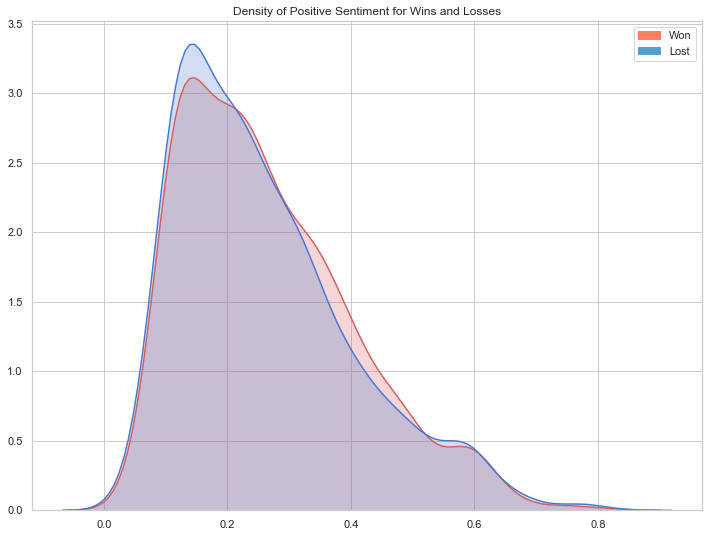

In [229]:
won_pos = won_df.loc[won_df['nltk_pos'] > 0]['nltk_pos']
lost_pos = lost_df.loc[lost_df['nltk_pos'] > 0]['nltk_pos']
p1 = sns.kdeplot(won_pos, shade=True, color='r')
p1 = sns.kdeplot(lost_pos, shade=True, color='b')
red_patch = mpatches.Patch(color=sns.color_palette('Reds')[2], label='Won')
blue_patch = mpatches.Patch(color=sns.color_palette('Blues')[3], label='Lost')
plt.legend(handles=[red_patch, blue_patch])
plt.title('Density of Positive Sentiment for Wins and Losses')
plt.show()

In [230]:
ca_df = pd.concat([frames[name] for name in ca], ignore_index=True)
ks_df = pd.concat([frames[name] for name in ks], ignore_index=True)
ga_df = pd.concat([frames[name] for name in ga], ignore_index=True)
sc_df = pd.concat([frames[name] for name in sc], ignore_index=True)
mt_df = pd.concat([frames[name] for name in mt], ignore_index=True)

In [231]:
ca_df = clean_add_sents(ca_df)
ks_df = clean_add_sents(ks_df)
ga_df = clean_add_sents(ga_df)
sc_df = clean_add_sents(sc_df)
mt_df = clean_add_sents(mt_df)

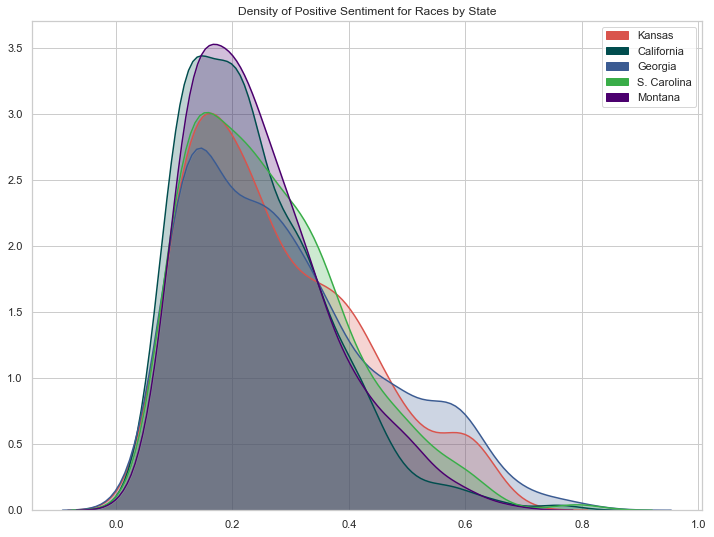

In [234]:
colors = {
    'red': [ks_df, sns.xkcd_rgb['pale red']],
    'teal': [ca_df, sns.xkcd_rgb['dark teal']],
    'blue': [ga_df, sns.xkcd_rgb['denim blue']],
    'green': [sc_df, sns.xkcd_rgb['medium green']],
    'purple': [mt_df, sns.xkcd_rgb['royal purple']],
}
for k, v in colors.items():
    sns.kdeplot(v[0].loc[v[0]['nltk_pos'] > 0]['nltk_pos'], color=v[1], shade=True)

handles = [mpatches.Patch(color=red, label='Kansas'),
           mpatches.Patch(color=teal, label='California'),
           mpatches.Patch(color=blue, label='Georgia'),
           mpatches.Patch(color=green, label='S. Carolina'),
           mpatches.Patch(color=purple, label='Montana')]
plt.legend(handles=[handle for handle in handles])
plt.title('Density of Positive Sentiment for Races by State')
plt.show()

In [267]:
won_df['win_loss'] = 1
won_df['label'] = 'w'
lost_df['win_loss'] = 0
lost_df['label'] = 'l'
wl_df = won_df.merge(lost_df, how='outer')

In [275]:
scoring = {'Precision': make_scorer(precision_score), 'Accuracy': make_scorer(accuracy_score)}
mnb_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])
svm_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', max_iter=100))
])
parameters= {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'vect__min_df': (1, 2, 3),
    'vect__stop_words': ('english', None),
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-1, 1e-2, 1e-3),
}
train_X, test_X, train_y, test_y = train_test_split(wl_df['text'].values, wl_df['win_loss'].values, test_size=0.3, random_state=123)

In [278]:
def run_grid_score(pipeline, name):
    clf = GridSearchCV(
        pipeline, 
        parameters,
        n_jobs=-1,
        scoring=scoring,
        refit='Accuracy'
    )
    clf.fit(train_X, train_y)
    print('#' * 50)
    print(f'\n{name} training set best score:', clf.best_score_, '\n')
    print('Training set best parameters:')
    display(clf.best_params_)
    print(f'Detailed classification report for {name} test set:')
    pred = clf.predict(test_X)
    display(classification_report(test_y, pred))
    print(f'Confustion Matrix for {name} test set:')
    display(confusion_matrix(test_y, pred))
run_grid_score(svm_pipe, 'SVM')
run_grid_score(mnb_pipe, 'MNB')

#########################

SVM training set: best score: 0.7950819672131147 

Training set best parameters:
{'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'} 

Detailed classification report for SVM test set:
             precision    recall  f1-score   support

          0       0.86      0.67      0.75       602
          1       0.75      0.90      0.82       653

avg / total       0.80      0.79      0.78      1255
 

Confustion Matrix for SVM test set:
[[403 199]
 [ 67 586]] 

#########################

MNB training set: best score: 0.8084016393442623 

Training set best parameters:
{'clf__alpha': 0.1, 'tfidf__use_idf': False, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'vect__stop_words': None} 

Detailed classification report for MNB test set:
             precision    recall  f1-score   support

          0       0.85      0.77      0.81       602
          1       0.80      0.87      0.84       653


In [300]:
def run_grid_for_upcoming(pipeline, model_name, upcoming_name, upcoming_X):
    clf = GridSearchCV(
        pipeline, 
        parameters,
        n_jobs=-1,
        scoring=scoring,
        refit='Accuracy'
    )
    clf.fit(train_X, train_y)
    print('\n', '#' * 50)
    print(f'\n{model_name} training set best score:', clf.best_score_, '\n')
    print('Training set best parameters:')
    display(clf.best_params_)
    print(f'Predicting upcoming race for {upcoming_name} with {model_name}')
    return clf.predict(upcoming_X)

In [301]:
upcoming_dfs = {
    'Andrew Gillum, FL Gov': {'df': andrew_fl},
    'Ron De Santis, FL Gov': {'df': ron_fl},
    'Scott Wagner, PA Gov': {'df': scott_pa},
    'Tom Wolf, PA Gov': {'df': tom_pa},
}

In [311]:
for name, nested in upcoming_dfs.items():
    temp_frame = clean_add_sents(nested['df'])
    preds = {
        'svm_pred': run_grid_for_upcoming(svm_pipe, 'SVM', name, temp_frame['text'].values),
        'mnb_pred': run_grid_for_upcoming(mnb_pipe, 'MNB', name, temp_frame['text'].values)
    }
    nested['preds'] = preds
    nested['cleaned_df'] = temp_frame
print('Ding! Fries are done.')

array(['😂✊🏾 https://t.co/g17jEaLD9Q',
       ' shellynnrn: Duval County, as expected, turned out close to 100 volunteers today! We called, texted, and canvassed! People power bringin…',
       ' CarlosGSmith: BringItHome ✊🏻✊🏼✊🏽✊🏾🌊 GillumForGovernor https://t.co/ZP9aFDchhw',
       'This is an environmental disaster on Rick Scott’s watch. I promise to help clean it up as your next Governor. https://t.co/dsZn4wwGRN',
       "I have a theory about why realDonaldTrump won't me...  if you agree. https://t.co/pZZOsW4vww",
       'We are going to make Florida a state where healthcare is treated like a right, not a privilege. https://t.co/54WVbyGNJ4',
       "I don't just believe that we will win. I KNOW that we will — because of our people-power. Let's BringItHome, Fl… https://t.co/90KYoolqXn",
       ' asweetvictori: An incredible opportunity, an incredible gubernatorial ticket! So ready to vote AndrewGillum ChrisKingFL BringItHome…',
       "If you haven't joined our movement yet, now is th

array(['Taxpayers deserve protection: if the legislature wants to raise your taxes, it should require a supermajority to do… https://t.co/hUa4itG2Mi',
       'As the Jewish holiday of Rosh Hashanah begins this evening, I would like to wish Shanah Tova to all of our Jewish f… https://t.co/XoOVTG2XLU',
       'I will fight for Florida’s great education programs, like the tax credit scholarship, that help some of the poorest… https://t.co/zXfDBY3ttY',
       'Join us tomorrow in Miami! RSVP here: https://t.co/uRx6XjlQFH https://t.co/j8tJqYqvZG',
       'Join RepJNunez and me tomorrow for our campaign rally in Miami! We’ll be at the Bay of Pigs Museum &amp; Library, door… https://t.co/ZzZAWyomqz',
       'Florida needs to diversify its economy to grow record new jobs in manufacturing, technology and financial services.',
       "The proper role of a court is to apply the law and constitution as it's written - not to rewrite it. I’ll only appo… https://t.co/P1XwZoeXOq",
       'As Governor,

array(['Great picnic in Lancaster this afternoon! Enjoyed talking about how we can work together to FixPA. https://t.co/npG1AsndKV',
       'I visited Dotzel Trucking and Topsoil yesterday to announce my plan to improve our economy in Pennsylvania. Here ar… https://t.co/urL2714z65',
       'Headed back to York this afternoon to inspect some of the recent flood damage. As governor, I pledge to work with m… https://t.co/DSRQCSW8uR',
       "Today I was pleased to announce my plan to empower Pennsylvania's economy. Read the full plan here →… https://t.co/n3rS4LScae",
       'While Tom Wolf blatantly avoids debate and continues to attempt to hide his true agenda from the voters, this websi… https://t.co/s6FLXQUtVG',
       'Since 1882, the first Monday in September has been dedicated to the massive contributions workers have made to the… https://t.co/vdLnzYH5KS',
       "A single 45 minute debate is not enough for the people of Pennsylvania. I'm eager to participate in the… https://t.co/vE

array(['When the Pennsylvania legislature didn’t act on the gender wage gap, I took action on equal pay. I will always stan… https://t.co/OBb624CPdD',
       'Kavanaugh’s support for overturning Roe v. Wade is a real threat. Governor Wolf will do everything in his power to… https://t.co/wUR5mIu4MA',
       'I promise to be a governor who will always stand up to Republican attempts to roll back Medicaid, defund Planned Pa… https://t.co/9zK8Tn3HeF',
       "As governor, Scott Wagner will, ✘ roll back Medicaid from 720,000 PA'ians, ✘ allow an age tax on seniors, ✘ defund… https://t.co/8U7iaQK752",
       "I will not back down from defending a woman's right to make her own health care decisions and standing up against R… https://t.co/y3YS6rhkW0",
       "It's time to get out the vote. Register now to keep Pennsylvania moving forward: https://t.co/2SydzPTXXw https://t.co/ATHzV6TYVr",
       'Thank you PghFFLocal1 for your commitment to protecting Pittsburgh residents and the rights of dedic

Ding! Fries are done.


In [328]:
for name, nested in upcoming_dfs.items():
    print('\n', '#' * 50, '\n')
    print(f'Sum for {name}, MNB Predictions:', nested['preds']['mnb_pred'].sum())
    nested['cleaned_df'] = nested['cleaned_df'].assign(mnb_pred=nested['preds']['mnb_pred'])
    print(f'Sum for {name}, SVM Predictions:', nested['preds']['svm_pred'].sum())
    nested['cleaned_df'] = nested['cleaned_df'].assign(svm_pred=nested['preds']['svm_pred'])
print('\n', '#' * 50, '\n')


 ################################################## 

Sum for Andrew Gillum, FL Gov, MNB Predictions: 280
Sum for Andrew Gillum, FL Gov, SVM Predictions: 332

 ################################################## 

Sum for Ron De Santis, FL Gov, MNB Predictions: 391
Sum for Ron De Santis, FL Gov, SVM Predictions: 423

 ################################################## 

Sum for Scott Wagner, PA Gov, MNB Predictions: 395
Sum for Scott Wagner, PA Gov, SVM Predictions: 434

 ################################################## 

Sum for Tom Wolf, PA Gov, MNB Predictions: 329
Sum for Tom Wolf, PA Gov, SVM Predictions: 389

 ################################################## 



In [329]:
tom_clean_predicted = upcoming_dfs['Tom Wolf, PA Gov']['cleaned_df']
scott_clean_predicted = upcoming_dfs['Scott Wagner, PA Gov']['cleaned_df']
ron_clean_predicted = upcoming_dfs['Ron De Santis, FL Gov']['cleaned_df']
andrew_clean_predicted = upcoming_dfs['Andrew Gillum, FL Gov']['cleaned_df']

In [343]:
confusion_matrix(andrew_clean_predicted.svm_pred, andrew_clean_predicted.mnb_pred)

array([[133,  35],
       [ 87, 245]])

In [361]:
upcoming_counts = pd.DataFrame(columns=['candidate', 'svm_sum', 'mnb_sum'])
for name, nested in upcoming_dfs.items():
    upcoming_counts.append(pd.DataFrame({
        'candidate': name, 
        'svm_sum': nested['preds']['svm_pred'].sum(),
    }, index=[0]), ignore_index=True)
upcoming_counts
# loss_counts = pd.DataFrame(data=lost_data)
# win_counts['win_loss'] = 'won'
# loss_counts['win_loss'] = 'lost'
# wl_counts = win_counts.merge(loss_counts, how='outer')
# wl_long = pd.melt(wl_counts, 'win_loss', var_name='count')

# sns.set(rc={'figure.figsize':(12, 9)})
# sns.set(style='whitegrid', palette='muted')
# sns.barplot(x='count', y='value', hue='win_loss', data=wl_long)
# plt.title('Sum of Retweets and Favorites by Candidates who Won and Lost')
# plt.xlabel('')
# plt.ylabel('')
# plt.show()

/Users/aoliv01/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,candidate,svm_sum,mnb_sum


In [348]:
wl_long

,win_loss,count,value
0,won,retweets,5
1,won,retweets,5
2,won,retweets,5
3,won,retweets,5
4,won,retweets,5
5,won,retweets,5
6,won,retweets,5
7,won,retweets,5
8,won,retweets,5
9,won,retweets,5
